# Control moment gyroscope

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import signal

# These are my own scripts
import ae353_cmg           # <-- interface to simulator
import ae353_cmg_analysis  # <-- derives state-space model

pybullet build time: Oct 28 2022 16:21:09


Choose equilibrium point.

In [2]:
q1e = np.pi
q2e = 0.
v1e = 0.
v2e = 0.
taue = 0.

Get state-space model.

In [3]:
A, B = ae353_cmg_analysis.get_model({
    'g': 9.81,
    'q1e': q1e,
    'q2e': q2e,
    'v1e': v1e,
    'v2e': v2e,
    'taue': taue,
})

print(f'A =\n{A}\n\nB =\n{B}')

A =
[[   0.            0.            1.            0.        ]
 [   0.            0.            0.            1.        ]
 [   4.34936821    0.            0.            1.10840168]
 [   0.            0.         -454.54545455    0.        ]]

B =
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [90.90909091]]


Check if the system is controllable.

In [4]:
W = np.block([B, A @ B, A @ A @ B, A @ A @ A @ B])
print(f'W =\n{W}\n')
print(f'rank(W) = {np.linalg.matrix_rank(W)}')

W =
[[     0.              0.            100.76378952      0.        ]
 [     0.             90.90909091      0.         -45801.72251118]
 [     0.            100.76378952      0.         -50328.4475738 ]
 [    90.90909091      0.         -45801.72251118      0.        ]]

rank(W) = 4


This function returns the solution to the LQR problem

$$\begin{align*} \underset{u_{[t_0,\infty]}}{\text{minimize}} &\qquad\int_{t_0}^{\infty} \left( x(t)^T Q x(t) + u(t)^T R u(t) \right) dt\\ \text{subject to} &\qquad\dot{x}(t)=Ax(t)+Bu(t) \\ &\qquad x(t_0)=x_0. \end{align*}$$

In [5]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K, P

Choose weights.

In [6]:
Q = np.diag([1., 1., 1., 1.])
R = np.diag([1.])

Find optimal gain matrix (and cost matrix).

In [7]:
K, P = lqr(A, B, Q, R)
print(f'K =\n{K}\n')

K =
[[12.90416849 -1.          3.00347062  1.02529954]]



Find closed-loop eigenvalues.

In [8]:
# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

p = [-84.96150598+0.j          -6.80911273+0.j
  -0.71921508+0.40767846j  -0.71921508-0.40767846j]


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

In [9]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=np.pi / 2,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Choose a default camera view (could also be `simulator.camera_topview()`).

In [10]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [11]:
class Controller:
    def __init__(self, K, q1e, q2e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.q2e = q2e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
        ):
        
        x = np.array([
            platform_angle - self.q1e,
            gimbal_angle - self.q2e,
            platform_velocity - self.v1e,
            gimbal_velocity - self.v2e,
        ])
        u = - self.K @ x
        gimbal_torque = u[0] + self.taue
        
        return gimbal_torque

Create an instance of the controller.

In [12]:
controller = Controller(K, q1e, q2e, v1e, v2e, taue)

Reset the simulator with given initial conditions. A separate PID controller, which you don't have to implement, will keep the rotor velocity constant.

In [13]:
simulator.reset(
    platform_angle=np.pi + 0.2,
    platform_velocity=0.,
    gimbal_angle=0.,
    gimbal_velocity=0.,
    rotor_velocity=500.,
)

Reset the controller.

In [14]:
controller.reset()

Run the simulator.

In [15]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot results.

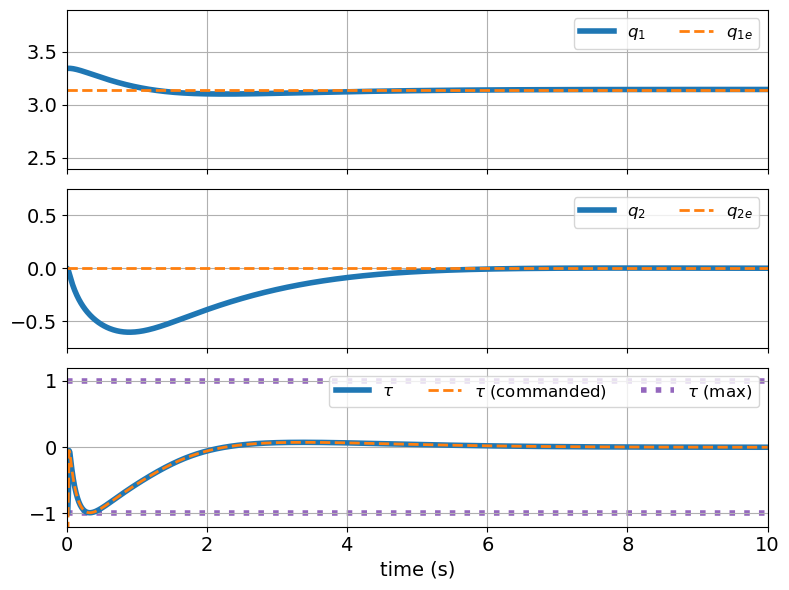

In [16]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_torque) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Plot platform angle
ax_platform.plot(
    data['t'], data['platform_angle'],
    label=r'$q_{1}$', linewidth=4,
)
ax_platform.plot(
    data['t'], q1e * np.ones_like(data['t']),
    '--', label=r'$q_{1e}$', linewidth=2,
)
ax_platform.grid()
ax_platform.legend(fontsize=12, ncol=2, loc='upper right')
ax_platform.tick_params(labelsize=14)
ax_platform.set_ylim(q1e - 0.75, q1e + 0.75)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label=r'$q_{2}$', linewidth=4,
)
ax_gimbal.plot(
    data['t'], q2e * np.ones_like(data['t']),
    '--', label=r'$q_{2e}$', linewidth=2,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=12, ncol=2, loc='upper right')
ax_gimbal.tick_params(labelsize=14)
ax_gimbal.set_ylim(q2e - 0.75, q2e + 0.75)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    label=r'$\tau$', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    '--', label=r'$\tau$ (commanded)', linewidth=2,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label=r'$\tau$ (max)', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=12, ncol=3, loc='upper right')
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=14)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()